## Imports Libraries

In [1]:
from sqlalchemy import create_engine
from sqlalchemy import inspect
import psycopg2
import psycopg2.extras
import statistics
import numpy as np
from numpy.polynomial.polynomial import polyfit
import pandas as pd
import geopandas as gpd
import json
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Task 1: Database

## Connect to Database

In [2]:
def pgconnect():
    conn = None
    db = create_engine('postgresql+psycopg2://'+'y22s1d2x01_qihe5305'+':'+'EQ9GDbky'+'@'+'soitpw11d59.shared.sydney.edu.au'+'/'+'y22s1d2x01_qihe5305'+'?gssencmode=disable', echo=False)
    conn = db.connect()
    print("connected")
    return db, conn


def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(sqlcmd, args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

In [67]:
db, conn = pgconnect()

connected


## Load and Cleaning Data

In [3]:
# Loading the csv


df_Neighbourhoods = pd.read_csv("Neighbourhoods.csv") # Neighbourhood dataset

df_Neighbourhoods.head()

,Unnamed: 0,area_id,area_name,land_area,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent,0-4,5-9,10-14,15-19
0,0,102011028,Avoca Beach - Copacabana,643.8,7590,2325,738.0,46996.0,1906.0,467,583,604,560
1,1,102011029,Box Head - MacMasters Beach,3208.6,10986,3847,907.0,42621.0,1682.0,586,696,661,692
2,2,102011030,Calga - Kulnura,76795.1,4841,1575,1102.0,42105.0,1182.0,220,254,304,320
3,3,102011031,Erina - Green Point,3379.3,14237,4450,1666.0,43481.0,1595.0,695,778,916,838
4,4,102011032,Gosford - Springfield,1691.2,19385,6373,2126.0,45972.0,1382.0,1200,1079,963,977


In [4]:
df_Business = pd.read_csv("BusinessStats.csv") # Business Stats dataset

df_Business.head()

,area_id,area_name,number_of_businesses,accommodation_and_food_services,retail_trade,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing
0,101021007,Braidwood,629,26,27,280,11,0,35
1,101021008,Karabar,326,7,10,8,11,0,43
2,101021009,Queanbeyan,724,52,47,11,56,3,77
3,101021010,Queanbeyan - East,580,16,23,4,12,0,57
4,101021011,Queanbeyan Region,1642,39,63,292,34,7,81


In [5]:
# Loading the shape files

SA2 = gpd.read_file("SA2_2016_AUST.shp") # SA2 Shape file

SA2.head()

,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16,geometry
0,101021007,11007,Braidwood,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3418.3525,"POLYGON ((149.58423 -35.44427, 149.58444 -35.4..."
1,101021008,11008,Karabar,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,6.9825,"POLYGON ((149.21898 -35.36739, 149.21799 -35.3..."
2,101021009,11009,Queanbeyan,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,4.7634,"POLYGON ((149.21325 -35.34325, 149.21619 -35.3..."
3,101021010,11010,Queanbeyan - East,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,13.0034,"POLYGON ((149.24033 -35.34782, 149.24023 -35.3..."
4,101021011,11011,Queanbeyan Region,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3054.4099,"POLYGON ((149.23580 -35.38738, 149.23771 -35.3..."


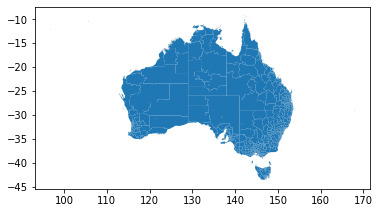

In [6]:
SA2.plot()

plt.show()

In [7]:
primary = gpd.read_file("catchments_primary.shp")
secondary = gpd.read_file("catchments_secondary.shp")
future = gpd.read_file("catchments_future.shp")
# Schools Shape files
print(primary.shape)
print(secondary.shape)
print(future.shape)

# Concating three levels of schools' data

schools = [primary, secondary, future]

schools = pd.concat(schools)

print(schools.shape)

schools.sample(5)

(1666, 19)
(435, 19)
(44, 18)
(2145, 19)


,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry
278,3951,PRIMARY,Marrickville WPS,None,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.14159 -33.91131, 151.14158 -33.9..."
1601,4407,PRIMARY,Hume PS,20200507,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((146.96276 -36.04976, 146.95464 -36.0..."
2,8505,HIGH_COED,Murray HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((146.81448 -35.78341, 146.81250 -35.7..."
1464,1140,CENTRAL_PRIMARY,Barraba CS,20200809,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((150.47736 -30.02654, 150.47878 -30.0..."
108,3420,PRIMARY,Wellington PS,20191223,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((149.10849 -32.11572, 149.10788 -32.1..."


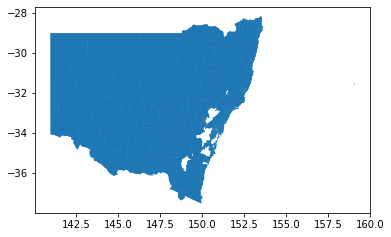

In [8]:
schools.plot()

plt.show()

In [9]:
Breakenter = gpd.read_file("BreakEnterDwelling_JanToDec2021.shp") # SA2 Shape file

print(Breakenter.shape)

Breakenter.head()

(2594, 7)


,OBJECTID,Contour,Density,ORIG_FID,Shape_Leng,Shape_Area,geometry
0,1,8.0,Low Density,1,0.012138,0.000006,"POLYGON ((149.91078 -37.06636, 149.91080 -37.0..."
1,2,8.0,Low Density,1,0.019106,0.000015,"POLYGON ((149.90601 -37.05837, 149.90602 -37.0..."
2,3,8.0,Low Density,1,0.006068,0.000002,"POLYGON ((148.94250 -37.04209, 148.94253 -37.0..."
3,4,8.0,Low Density,1,0.011006,0.000006,"POLYGON ((149.19583 -36.91833, 149.19584 -36.9..."
4,5,8.0,Low Density,1,0.008073,0.000003,"POLYGON ((149.84836 -36.68459, 149.84838 -36.6..."


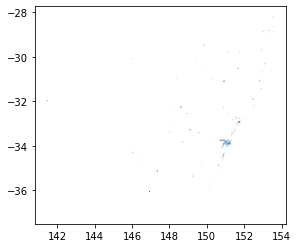

In [10]:
Breakenter.plot()

plt.show()

In [11]:
# Drop rows with NULLs

df_Neighbourhoods.dropna(inplace=True)

df_Business.dropna(inplace=True)

SA2.dropna(inplace=True)

# schools.dropna(inplace=True)

## Create schema into database and insert records

In [12]:
df_Neighbourhoods.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 309 entries, 0 to 321
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      309 non-null    int64  
 1   area_id                         309 non-null    int64  
 2   area_name                       309 non-null    object 
 3   land_area                       309 non-null    float64
 4   population                      309 non-null    object 
 5   number_of_dwellings             309 non-null    object 
 6   number_of_businesses            309 non-null    float64
 7   median_annual_household_income  309 non-null    float64
 8   avg_monthly_rent                309 non-null    float64
 9   0-4                             309 non-null    int64  
 10  5-9                             309 non-null    int64  
 11  10-14                           309 non-null    int64  
 12  15-19                           309 

In [13]:
df_Business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2301 entries, 0 to 2300
Data columns (total 9 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   area_id                            2301 non-null   int64 
 1   area_name                          2301 non-null   object
 2   number_of_businesses               2301 non-null   int64 
 3   accommodation_and_food_services    2301 non-null   int64 
 4   retail_trade                       2301 non-null   int64 
 5   agriculture_forestry_and_fishing   2301 non-null   int64 
 6   health_care_and_social_assistance  2301 non-null   int64 
 7   public_administration_and_safety   2301 non-null   int64 
 8   transport_postal_and_warehousing   2301 non-null   int64 
dtypes: int64(8), object(1)
memory usage: 161.9+ KB


In [14]:
SA2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2292 entries, 0 to 2307
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   SA2_MAIN16  2292 non-null   object  
 1   SA2_5DIG16  2292 non-null   object  
 2   SA2_NAME16  2292 non-null   object  
 3   SA3_CODE16  2292 non-null   object  
 4   SA3_NAME16  2292 non-null   object  
 5   SA4_CODE16  2292 non-null   object  
 6   SA4_NAME16  2292 non-null   object  
 7   GCC_CODE16  2292 non-null   object  
 8   GCC_NAME16  2292 non-null   object  
 9   STE_CODE16  2292 non-null   object  
 10  STE_NAME16  2292 non-null   object  
 11  AREASQKM16  2292 non-null   float64 
 12  geometry    2292 non-null   geometry
dtypes: float64(1), geometry(1), object(11)
memory usage: 250.7+ KB


In [15]:
schools.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2145 entries, 0 to 43
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   USE_ID      2145 non-null   object  
 1   CATCH_TYPE  2145 non-null   object  
 2   USE_DESC    2145 non-null   object  
 3   ADD_DATE    1589 non-null   object  
 4   KINDERGART  2145 non-null   object  
 5   YEAR1       2145 non-null   object  
 6   YEAR2       2145 non-null   object  
 7   YEAR3       2145 non-null   object  
 8   YEAR4       2145 non-null   object  
 9   YEAR5       2145 non-null   object  
 10  YEAR6       2145 non-null   object  
 11  YEAR7       2145 non-null   object  
 12  YEAR8       2145 non-null   object  
 13  YEAR9       2145 non-null   object  
 14  YEAR10      2145 non-null   object  
 15  YEAR11      2145 non-null   object  
 16  YEAR12      2145 non-null   object  
 17  PRIORITY    9 non-null      object  
 18  geometry    2145 non-null   geometry
dtype

In [16]:
Breakenter.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2594 entries, 0 to 2593
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    2594 non-null   int64   
 1   Contour     2594 non-null   float64 
 2   Density     2594 non-null   object  
 3   ORIG_FID    2594 non-null   int64   
 4   Shape_Leng  2594 non-null   float64 
 5   Shape_Area  2594 non-null   float64 
 6   geometry    2594 non-null   geometry
dtypes: float64(3), geometry(1), int64(2), object(1)
memory usage: 142.0+ KB


In [68]:
conn.execute("set search_path to public")

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(sqlcmd, args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

In [39]:
conn.execute("""
DROP TABLE IF EXISTS Neighbourhoods;
CREATE TABLE Neighbourhoods( 
    area_id INT PRIMARY KEY, 
    area_name TEXT, 
    land_area FLOAT, 
    population FLOAT,
    number_of_dwellings FLOAT, 
    number_of_businesses FLOAT,
    median_annual_household_income FLOAT,
    avg_monthly_rent FLOAT,
    "0-4" INT,
    "5-9" INT,
    "10-14" INT,
    "14-19" INT
);""")

df_Neighbourhoods.to_sql("Neighbourhoods", con=conn, if_exists='replace', index=False)

309

In [13]:
query(conn, 'select * from public."Neighbourhoods"')

,Unnamed: 0,area_id,area_name,land_area,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent,0-4,5-9,10-14,15-19,geom,geom_g
0,0,102011028,Avoca Beach - Copacabana,643.8000,7590,2325,738.0,46996.0,1906.0,467,583,604,560,None,None
1,1,102011029,Box Head - MacMasters Beach,3208.6000,10986,3847,907.0,42621.0,1682.0,586,696,661,692,None,None
2,2,102011030,Calga - Kulnura,76795.1000,4841,1575,1102.0,42105.0,1182.0,220,254,304,320,None,None
3,3,102011031,Erina - Green Point,3379.3000,14237,4450,1666.0,43481.0,1595.0,695,778,916,838,None,None
4,4,102011032,Gosford - Springfield,1691.2000,19385,6373,2126.0,45972.0,1382.0,1200,1079,963,977,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,317,106011109,Cessnock Region,1570.4341,"7,931","3,281",673.0,73164.0,1080.0,432,590,577,527,None,None
305,318,106011113,Singleton Region,4067.2349,"4,919","2,055",698.0,87984.0,1000.0,310,394,353,323,None,None
306,319,111021218,Morisset - Cooranbong,330.5208,"14,959","6,298",1154.0,58084.0,1260.0,813,855,828,962,None,None
307,320,114021285,Hill Top - Colo Vale,174.3752,"6,025","2,249",400.0,81120.0,1512.0,443,500,470,451,None,None


In [18]:
conn.execute("""
DROP TABLE IF EXISTS Business;
CREATE TABLE Business( 
    area_id INTEGER PRIMARY KEY, 
    area_name VARCHAR(100), 
    number_of_businesses INTEGER,
    accommodation_and_food_services INTEGER,
    retail_trade INTEGER,
    agriculture_forestry_and_fishing INTEGER, 
    health_care_and_social_assistance INTEGER,
    public_administration_and_safety INTEGER,
    transport_postal_and_warehousing INTEGER
);""")

#   FOREIGN KEY (area_id) REFERENCES Neighbourhoods(area_id)

df_Business.to_sql("Business", con=conn, if_exists='replace', index=False)

,area_id,area_name,number_of_businesses,accommodation_and_food_services,retail_trade,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing
0,101021007,Braidwood,629,26,27,280,11,0,35
1,101021008,Karabar,326,7,10,8,11,0,43
2,101021009,Queanbeyan,724,52,47,11,56,3,77
3,101021010,Queanbeyan - East,580,16,23,4,12,0,57
4,101021011,Queanbeyan Region,1642,39,63,292,34,7,81
...,...,...,...,...,...,...,...,...,...
2296,901011001,Christmas Island,0,0,0,0,0,0,0
2297,901021002,Cocos (Keeling) Islands,7,3,0,0,0,0,0
2298,901031003,Jervis Bay,6,0,3,0,0,0,0
2299,901041004,Norfolk Island,0,0,0,0,0,0,0


In [16]:
query(conn, 'select * from public."Business"')

,area_id,area_name,number_of_businesses,accommodation_and_food_services,retail_trade,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing
0,101021007,Braidwood,629,26,27,280,11,0,35
1,101021008,Karabar,326,7,10,8,11,0,43
2,101021009,Queanbeyan,724,52,47,11,56,3,77
3,101021010,Queanbeyan - East,580,16,23,4,12,0,57
4,101021011,Queanbeyan Region,1642,39,63,292,34,7,81
...,...,...,...,...,...,...,...,...,...
2296,901011001,Christmas Island,0,0,0,0,0,0,0
2297,901021002,Cocos (Keeling) Islands,7,3,0,0,0,0,0
2298,901031003,Jervis Bay,6,0,3,0,0,0,0
2299,901041004,Norfolk Island,0,0,0,0,0,0,0


In [18]:
srid = 4326

def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

In [19]:
SA2_copy = SA2.copy()  # Creating a copy of the original SA2
SA2['geom'] = SA2['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
SA2 = SA2.drop(columns="geometry")  # Deleting the old copy of SA2
SA2.sample(5)

,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16,geom
1089,303011048,31048,Cannon Hill,30301,Carindale,303,Brisbane - South,3GBRI,Greater Brisbane,3,Queensland,3.9526,MULTIPOLYGON (((153.08185560800007 -27.4623629...
1553,319021510,31510,North Burnett,31902,Burnett,319,Wide Bay,3RQLD,Rest of Qld,3,Queensland,289.5233,MULTIPOLYGON (((151.45528099600006 -24.5708999...
1116,303051075,31075,Parkinson - Drewvale,30305,Rocklea - Acacia Ridge,303,Brisbane - South,3GBRI,Greater Brisbane,3,Queensland,12.6742,MULTIPOLYGON (((153.0217020010001 -27.62933699...
1011,215031405,21405,Swan Hill Region,21503,Murray River - Swan Hill,215,North West,2RVIC,Rest of Vic.,2,Victoria,5759.2126,MULTIPOLYGON (((142.74296193100008 -35.1150331...
631,204011054,21054,Alexandra,20401,Upper Goulburn Valley,204,Hume,2RVIC,Rest of Vic.,2,Victoria,2118.9554,MULTIPOLYGON (((145.59014475900005 -37.2247833...


In [21]:
query(conn, "select PostGIS_Version()")

,postgis_version
0,3.0 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


In [21]:
conn.execute('''DROP TABLE IF EXISTS SA2;
                CREATE TABLE SA2(
                     sa2_maincode INT,
                     sa2_5digitcode INT,
                     sa2_name16  TEXT,
                     sa3_code16 INT,
                     sa3_name16 TEXT,
                     sa4_code TEXT,
                     sa4_name TEXT,
                     gccsa_code TEXT,
                     gccsa_name TEXT,
                     state_code INT,
                     state_name TEXT,
                     area_in_sqkm NUMERIC,
                     geom GEOMETRY(MULTIPOLYGON, 4326)
                     )''')

#                     CONSTRAINT fk_area_id
#                    FOREIGN KEY(sa2_maincode),
#                    REFERENCES public."Neighbourhoods"(area_id))

SA2.to_sql('SA2', conn, if_exists='replace', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})

In [27]:
query(conn, 'select * from public."SA2"')

,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16,geom
0,101021007,11007,Braidwood,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3418.3525,0106000020E6100000010000000103000000010000005F...
1,101021008,11008,Karabar,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,6.9825,0106000020E6100000010000000103000000010000002C...
2,101031015,11015,Cooma Region,10103,Snowy Mountains,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,6250.8748,0106000020E6100000010000000103000000020000006E...
3,101031016,11016,Jindabyne - Berridale,10103,Snowy Mountains,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3939.5484,0106000020E6100000010000000103000000010000005F...
4,101041017,11017,Batemans Bay,10104,South Coast,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,63.7074,0106000020E61000000100000001030000000100000036...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2287,801111141,81141,Namadgi,80111,Urriarra - Namadgi,801,Australian Capital Territory,8ACTE,Australian Capital Territory,8,Australian Capital Territory,1202.8930,0106000020E6100000010000000103000000010000000C...
2288,901011001,91001,Christmas Island,90101,Christmas Island,901,Other Territories,9OTER,Other Territories,9,Other Territories,136.1356,0106000020E61000000100000001030000000100000094...
2289,901021002,91002,Cocos (Keeling) Islands,90102,Cocos (Keeling) Islands,901,Other Territories,9OTER,Other Territories,9,Other Territories,13.7163,0106000020E6100000380000000103000000010000000E...
2290,901031003,91003,Jervis Bay,90103,Jervis Bay,901,Other Territories,9OTER,Other Territories,9,Other Territories,67.8134,0106000020E61000000300000001030000000100000017...


In [20]:
schools_copy = schools.copy()  # Creating a copy of the original Schools dataset
schools['geom'] = schools['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
schools = schools.drop(columns="geometry")  # Deleting the old copy of Schools dataset

schools['KINDERGART']=schools['KINDERGART'].str.replace('0','N').replace("2023", "Y")
schools['YEAR1']=schools['YEAR1'].str.replace('0','N').replace("2023", "Y")
schools['YEAR2']=schools['YEAR1'].str.replace('0','N').replace("2023", "Y")
schools['YEAR3']=schools['YEAR1'].str.replace('0','N').replace("2023", "Y")
schools['YEAR4']=schools['YEAR1'].str.replace('0','N').replace("2023", "Y")
schools['YEAR5']=schools['YEAR1'].str.replace('0','N').replace("2023", "Y")
schools['YEAR6']=schools['YEAR1'].str.replace('0','N').replace("2023", "Y")
schools['YEAR7']=schools['YEAR1'].str.replace('0','N').replace("2023", "Y")
schools['YEAR8']=schools['YEAR1'].str.replace('0','N').replace("2023", "Y")
schools['YEAR9']=schools['YEAR1'].str.replace('0','N').replace("2023", "Y")
schools['YEAR10']=schools['YEAR1'].str.replace('0','N').replace("2023", "Y")
schools['YEAR11']=schools['YEAR1'].str.replace('0','N').replace("2023", "Y")
schools['YEAR12']=schools['YEAR1'].str.replace('0','N').replace("2023", "Y")

schools.sample(5)

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geom
1304,1175,PRIMARY,Bellata PS,20200121,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,None,MULTIPOLYGON (((150.07188660880473 -29.8355841...
1477,4379,PRIMARY,Floraville PS,20210814,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,None,MULTIPOLYGON (((151.67042923383778 -32.9875712...
617,2784,PRIMARY,Nymboida PS,20211130,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,None,MULTIPOLYGON (((152.63451963423415 -29.8089277...
636,1788,PRIMARY,Dundurrabin PS,20211130,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,None,MULTIPOLYGON (((152.7071754773205 -30.10132887...
396,1055,CENTRAL_HIGH,Ariah Park CS,20200521,N,N,N,N,N,N,N,N,N,N,N,N,N,None,MULTIPOLYGON (((147.32522746900943 -34.0433407...


In [77]:
conn.execute('''DROP TABLE IF EXISTS Schools;
                CREATE TABLE Schools(
                USE_ID TEXT,
                CATCH_TYPE TEXT,
                USE_DESC TEXT,
                ADD_DATE TEXT,
                KINDERGART TEXT,
                YEAR1 TEXT,
                YEAR2 TEXT, 
                YEAR3 TEXT,
                YEAR4 TEXT,
                YEAR5 TEXT,
                YEAR6 TEXT,
                YEAR7 TEXT,
                YEAR8 TEXT,
                YEAR9 TEXT,
                YEAR10 TEXT,
                YEAR11 TEXT,
                YEAR12 TEXT,
                PRIORITY TEXT,
                geometry GEOMETRY(MULTIPOLYGON, 4326)
                )''')

schools.to_sql('Schools', conn, if_exists='replace', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})

In [20]:
query(conn, 'select * from public."Schools"')

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geom
0,2838,PRIMARY,Parklea PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E61000000100000001030000000100000078...
1,3943,PRIMARY,Gordon WPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E6100000010000000103000000010000006F...
2,2404,PRIMARY,Lindfield EPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E610000001000000010300000001000000BE...
3,1839,PRIMARY,Empire Bay PS,20211115,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E61000000100000001030000000100000032...
4,4393,PRIMARY,Carlingford WPS,20220223,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E61000000100000001030000000100000065...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2140,8524,HIGH_COED,Karabar HS,20220305,0,0,0,0,0,0,0,2023,2023,2023,2023,2023,2023,None,0106000020E6100000010000000103000000010000006E...
2141,4680,PRIMARY,Googong PS,20220305,2023,2023,2023,2023,2023,2023,2023,0,0,0,0,0,0,None,0106000020E61000000100000001030000000100000072...
2142,2540,PRIMARY,Michelago PS,20220305,2023,2023,2023,2023,2023,2023,2023,0,0,0,0,0,0,None,0106000020E610000001000000010300000001000000BF...
2143,8922,HIGH_COED,Jerrabomberra HS,20220305,0,0,0,0,0,0,0,2023,2023,0,0,0,0,None,0106000020E61000000100000001030000000100000020...


In [30]:
Breakenter_copy = Breakenter.copy()  # Creating a copy of the original SA2
Breakenter['geom'] = Breakenter['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
Breakenter = Breakenter.drop(columns="geometry")  # Deleting the old copy of SA2
Breakenter.sample(5)

,OBJECTID,Contour,Density,ORIG_FID,Shape_Leng,Shape_Area,geom
2226,2227,10.0,High Density,3,0.029594,0.000042,MULTIPOLYGON (((151.1557333170001 -33.92671003...
2168,2169,10.0,High Density,3,0.019902,0.000019,MULTIPOLYGON (((150.92145418300004 -34.3649421...
1516,1517,9.0,Medium Density,2,0.011003,0.000005,MULTIPOLYGON (((151.13948548500002 -33.8811923...
1569,1570,9.0,Medium Density,2,0.048158,0.000056,MULTIPOLYGON (((151.21481383700007 -33.8380395...
1195,1196,8.0,Low Density,1,0.018433,0.000014,MULTIPOLYGON (((153.60613826200006 -28.6844582...


In [21]:
conn.execute('''DROP TABLE IF EXISTS Breakenter;
                CREATE TABLE Breakenter(
                OBJECTID INT,
                Contour FLOAT,
                Density TEXT,
                ORIG_FID INT,
                Shape_Leng FLOAT,
                Shape_Area FLOAT,
                geometry GEOMETRY(MULTIPOLYGON, 4326)
                )''')

Breakenter.to_sql('Breakenter', conn, if_exists='replace', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})

594

In [19]:
query(conn, 'select * from public."Breakenter"')

,OBJECTID,Contour,Density,ORIG_FID,Shape_Leng,Shape_Area,geom
0,1,8.0,Low Density,1,0.012138,0.000006,0106000020E61000000100000001030000000100000015...
1,2,8.0,Low Density,1,0.019106,0.000015,0106000020E6100000010000000103000000010000001D...
2,3,8.0,Low Density,1,0.006068,0.000002,0106000020E61000000100000001030000000100000007...
3,4,8.0,Low Density,1,0.011006,0.000006,0106000020E6100000010000000103000000010000000E...
4,5,8.0,Low Density,1,0.008073,0.000003,0106000020E6100000010000000103000000010000000F...
...,...,...,...,...,...,...,...
2589,2590,10.0,High Density,3,0.015358,0.000011,0106000020E61000000100000001030000000100000016...
2590,2591,10.0,High Density,3,0.028327,0.000029,0106000020E61000000100000001030000000100000028...
2591,2592,10.0,High Density,3,0.006654,0.000002,0106000020E61000000100000001030000000100000009...
2592,2593,10.0,High Density,3,0.047098,0.000044,0106000020E6100000010000000103000000010000004D...


# Task 2: Greater Sydney liveability score

## Create Index for better data integration

In [93]:
index = "name_area"
table = 'public."Neighbourhoods"'
column = 'area_name'


conn.execute(f'CREATE INDEX {index} ON {table} ({column})')

In [95]:
index = "b_name_area"
table = 'public."Business"'
column = 'area_name'

conn.execute(f'CREATE INDEX {index} ON {table} ({column})')

## Relational Join

In [102]:
conn.execute('''ALTER TABLE "Neighbourhoods" ADD COLUMN geom_g geometry(MULTIPOLYGON, 4326)''') 
conn.execute('''UPDATE "Neighbourhoods" as N 
                    SET geom_g = (
                        SELECT geom_g 
                          FROM SA2
                         WHERE SA2.sa2_name16 = N.area_name
                    );''') 

In [ ]:
# Indexes: school, accom, retail, crime, health

In [21]:
# Merging datasets

df_Live = df_Neighbourhoods.merge(df_Business, on = "area_id", how='left')

df_Live.drop(['area_name_y', 'number_of_businesses_y'], axis = 1, inplace=True)

df_Live['population']=df_Live['population'].str.replace(',','')

df_Live["population"] = pd.to_numeric(df_Live['population'])

df_Live.head()

,Unnamed: 0,area_id,area_name_x,land_area,population,number_of_dwellings,number_of_businesses_x,median_annual_household_income,avg_monthly_rent,0-4,5-9,10-14,15-19,accommodation_and_food_services,retail_trade,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing
0,0,102011028,Avoca Beach - Copacabana,643.8,7590,2325,738.0,46996.0,1906.0,467,583,604,560,33,35,4,60,0,19
1,1,102011029,Box Head - MacMasters Beach,3208.6,10986,3847,907.0,42621.0,1682.0,586,696,661,692,23,45,13,43,3,28
2,2,102011030,Calga - Kulnura,76795.1,4841,1575,1102.0,42105.0,1182.0,220,254,304,320,14,43,231,12,0,55
3,3,102011031,Erina - Green Point,3379.3,14237,4450,1666.0,43481.0,1595.0,695,778,916,838,68,145,19,179,12,43
4,4,102011032,Gosford - Springfield,1691.2,19385,6373,2126.0,45972.0,1382.0,1200,1079,963,977,94,167,9,246,10,97


### accom

In [22]:
# accom

df_Live["per_thousand_people"] = df_Live["population"] / 1000

df_Live.dropna(inplace=True)

df_Live["accom"] = df_Live["accommodation_and_food_services"] / df_Live["per_thousand_people"]

df_Live.head()

,Unnamed: 0,area_id,area_name_x,land_area,population,number_of_dwellings,number_of_businesses_x,median_annual_household_income,avg_monthly_rent,0-4,...,10-14,15-19,accommodation_and_food_services,retail_trade,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing,per_thousand_people,accom
0,0,102011028,Avoca Beach - Copacabana,643.8,7590,2325,738.0,46996.0,1906.0,467,...,604,560,33,35,4,60,0,19,7.590,4.347826
1,1,102011029,Box Head - MacMasters Beach,3208.6,10986,3847,907.0,42621.0,1682.0,586,...,661,692,23,45,13,43,3,28,10.986,2.093574
2,2,102011030,Calga - Kulnura,76795.1,4841,1575,1102.0,42105.0,1182.0,220,...,304,320,14,43,231,12,0,55,4.841,2.891964
3,3,102011031,Erina - Green Point,3379.3,14237,4450,1666.0,43481.0,1595.0,695,...,916,838,68,145,19,179,12,43,14.237,4.776287
4,4,102011032,Gosford - Springfield,1691.2,19385,6373,2126.0,45972.0,1382.0,1200,...,963,977,94,167,9,246,10,97,19.385,4.849110


### retail

In [23]:
# retail

df_Live["retail"] = df_Live["retail_trade"] / df_Live["per_thousand_people"]

df_Live.head()

,Unnamed: 0,area_id,area_name_x,land_area,population,number_of_dwellings,number_of_businesses_x,median_annual_household_income,avg_monthly_rent,0-4,...,15-19,accommodation_and_food_services,retail_trade,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing,per_thousand_people,accom,retail
0,0,102011028,Avoca Beach - Copacabana,643.8,7590,2325,738.0,46996.0,1906.0,467,...,560,33,35,4,60,0,19,7.590,4.347826,4.611331
1,1,102011029,Box Head - MacMasters Beach,3208.6,10986,3847,907.0,42621.0,1682.0,586,...,692,23,45,13,43,3,28,10.986,2.093574,4.096122
2,2,102011030,Calga - Kulnura,76795.1,4841,1575,1102.0,42105.0,1182.0,220,...,320,14,43,231,12,0,55,4.841,2.891964,8.882462
3,3,102011031,Erina - Green Point,3379.3,14237,4450,1666.0,43481.0,1595.0,695,...,838,68,145,19,179,12,43,14.237,4.776287,10.184730
4,4,102011032,Gosford - Springfield,1691.2,19385,6373,2126.0,45972.0,1382.0,1200,...,977,94,167,9,246,10,97,19.385,4.849110,8.614908


### health

In [24]:
# health

df_Live["health"] = df_Live["health_care_and_social_assistance"] / df_Live["per_thousand_people"]

df_Live.head()

,Unnamed: 0,area_id,area_name_x,land_area,population,number_of_dwellings,number_of_businesses_x,median_annual_household_income,avg_monthly_rent,0-4,...,accommodation_and_food_services,retail_trade,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing,per_thousand_people,accom,retail,health
0,0,102011028,Avoca Beach - Copacabana,643.8,7590,2325,738.0,46996.0,1906.0,467,...,33,35,4,60,0,19,7.590,4.347826,4.611331,7.905138
1,1,102011029,Box Head - MacMasters Beach,3208.6,10986,3847,907.0,42621.0,1682.0,586,...,23,45,13,43,3,28,10.986,2.093574,4.096122,3.914072
2,2,102011030,Calga - Kulnura,76795.1,4841,1575,1102.0,42105.0,1182.0,220,...,14,43,231,12,0,55,4.841,2.891964,8.882462,2.478827
3,3,102011031,Erina - Green Point,3379.3,14237,4450,1666.0,43481.0,1595.0,695,...,68,145,19,179,12,43,14.237,4.776287,10.184730,12.572873
4,4,102011032,Gosford - Springfield,1691.2,19385,6373,2126.0,45972.0,1382.0,1200,...,94,167,9,246,10,97,19.385,4.849110,8.614908,12.690224


In [25]:
df_Live.dropna(inplace=True)

SA2["area_id"] = SA2["SA2_MAIN16"]

SA2.info()

SA2["area_id"] = pd.to_numeric(SA2["area_id"])

df_Live = df_Live.merge(SA2, on = "area_id", how='left')

df_Live.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2292 entries, 0 to 2307
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SA2_MAIN16  2292 non-null   object 
 1   SA2_5DIG16  2292 non-null   object 
 2   SA2_NAME16  2292 non-null   object 
 3   SA3_CODE16  2292 non-null   object 
 4   SA3_NAME16  2292 non-null   object 
 5   SA4_CODE16  2292 non-null   object 
 6   SA4_NAME16  2292 non-null   object 
 7   GCC_CODE16  2292 non-null   object 
 8   GCC_NAME16  2292 non-null   object 
 9   STE_CODE16  2292 non-null   object 
 10  STE_NAME16  2292 non-null   object 
 11  AREASQKM16  2292 non-null   float64
 12  geom        2292 non-null   object 
 13  area_id     2292 non-null   object 
dtypes: float64(1), object(13)
memory usage: 268.6+ KB


,Unnamed: 0,area_id,area_name_x,land_area,population,number_of_dwellings,number_of_businesses_x,median_annual_household_income,avg_monthly_rent,0-4,...,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16,geom
0,0,102011028,Avoca Beach - Copacabana,643.8,7590,2325,738.0,46996.0,1906.0,467,...,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,6.4376,MULTIPOLYGON (((151.4137275700001 -33.46559324...
1,1,102011029,Box Head - MacMasters Beach,3208.6,10986,3847,907.0,42621.0,1682.0,586,...,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,32.0860,MULTIPOLYGON (((151.3539836770001 -33.49854010...
2,2,102011030,Calga - Kulnura,76795.1,4841,1575,1102.0,42105.0,1182.0,220,...,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,767.9512,MULTIPOLYGON (((151.20459505400004 -33.5329829...
3,3,102011031,Erina - Green Point,3379.3,14237,4450,1666.0,43481.0,1595.0,695,...,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,33.7934,MULTIPOLYGON (((151.36794832200007 -33.4382241...
4,4,102011032,Gosford - Springfield,1691.2,19385,6373,2126.0,45972.0,1382.0,1200,...,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,16.9124,MULTIPOLYGON (((151.310060818 -33.426989095999...


In [26]:
# USE Spatial JOIN

geometry = SA2_copy["geometry"]

df_Live = gpd.GeoDataFrame(df_Live, crs="EPSG:4326", geometry=geometry)

df_Live = df_Live.sjoin(schools_copy, how="left")

C:\Users\Melo\AppData\Local\Temp\ipykernel_35116\3736466023.py:5: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  df_Live = gpd.GeoDataFrame(df_Live, crs="EPSG:4326", geometry=geometry)


In [31]:
df_Live = df_Live.rename(columns={'index_left':'other_name', 'index_right':'other_names'})

Breakenter_copy = Breakenter_copy.to_crs(4283)

df_Live = df_Live.sjoin(Breakenter_copy, how="inner")

df_Live.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 22692 entries, 0 to 308
Data columns (total 63 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   Unnamed: 0                         22692 non-null  int64   
 1   area_id                            22692 non-null  int64   
 2   area_name_x                        22692 non-null  object  
 3   land_area                          22692 non-null  float64 
 4   population                         22692 non-null  int64   
 5   number_of_dwellings                22692 non-null  object  
 6   number_of_businesses_x             22692 non-null  float64 
 7   median_annual_household_income     22692 non-null  float64 
 8   avg_monthly_rent                   22692 non-null  float64 
 9   0-4                                22692 non-null  int64   
 10  5-9                                22692 non-null  int64   
 11  10-14                              

### crime

In [32]:
# crime

df_Live["crime"] = df_Live["Shape_Area"] / df_Live["land_area"]

df_Live.head()

,Unnamed: 0,area_id,area_name_x,land_area,population,number_of_dwellings,number_of_businesses_x,median_annual_household_income,avg_monthly_rent,0-4,...,YEAR12,PRIORITY,index_right,OBJECTID,Contour,Density,ORIG_FID,Shape_Leng,Shape_Area,crime
0,0,102011028,Avoca Beach - Copacabana,643.8,7590,2325,738.0,46996.0,1906.0,467,...,Y,None,37,38,8.0,Low Density,1,0.011134,0.000006,9.277921e-09
0,0,102011028,Avoca Beach - Copacabana,643.8,7590,2325,738.0,46996.0,1906.0,467,...,N,None,37,38,8.0,Low Density,1,0.011134,0.000006,9.277921e-09
0,0,102011028,Avoca Beach - Copacabana,643.8,7590,2325,738.0,46996.0,1906.0,467,...,Y,None,37,38,8.0,Low Density,1,0.011134,0.000006,9.277921e-09
0,0,102011028,Avoca Beach - Copacabana,643.8,7590,2325,738.0,46996.0,1906.0,467,...,N,None,37,38,8.0,Low Density,1,0.011134,0.000006,9.277921e-09
0,0,102011028,Avoca Beach - Copacabana,643.8,7590,2325,738.0,46996.0,1906.0,467,...,N,None,37,38,8.0,Low Density,1,0.011134,0.000006,9.277921e-09


### school

In [33]:
# school

df_Live["per_thousand_young_people"] = (df_Live["0-4"] + df_Live["5-9"] + df_Live["10-14"] + df_Live["15-19"]) / 1000 


schools_count = df_Live["area_id"].value_counts()

schools_count = pd.DataFrame(schools_count)

schools_count = schools_count.reset_index()
schools_count.columns=['area_id', 'school_amount']
print(schools_count.head())

df_Live = df_Live.merge(schools_count, on = "area_id", how='left')

df_Live["school"] = df_Live["school_amount"] / df_Live["per_thousand_young_people"]

df_Live.head()

     area_id  school_amount
0  126021501            480
1  124031464            464
2  122021422            380
3  118021568            364
4  117031338            320


,Unnamed: 0,area_id,area_name_x,land_area,population,number_of_dwellings,number_of_businesses_x,median_annual_household_income,avg_monthly_rent,0-4,...,OBJECTID,Contour,Density,ORIG_FID,Shape_Leng,Shape_Area,crime,per_thousand_young_people,school_amount,school
0,0,102011028,Avoca Beach - Copacabana,643.8,7590,2325,738.0,46996.0,1906.0,467,...,38,8.0,Low Density,1,0.011134,0.000006,9.277921e-09,2.214,48,21.680217
1,0,102011028,Avoca Beach - Copacabana,643.8,7590,2325,738.0,46996.0,1906.0,467,...,38,8.0,Low Density,1,0.011134,0.000006,9.277921e-09,2.214,48,21.680217
2,0,102011028,Avoca Beach - Copacabana,643.8,7590,2325,738.0,46996.0,1906.0,467,...,38,8.0,Low Density,1,0.011134,0.000006,9.277921e-09,2.214,48,21.680217
3,0,102011028,Avoca Beach - Copacabana,643.8,7590,2325,738.0,46996.0,1906.0,467,...,38,8.0,Low Density,1,0.011134,0.000006,9.277921e-09,2.214,48,21.680217
4,0,102011028,Avoca Beach - Copacabana,643.8,7590,2325,738.0,46996.0,1906.0,467,...,38,8.0,Low Density,1,0.011134,0.000006,9.277921e-09,2.214,48,21.680217


## z score

In [34]:
df_Live["z_school"] = (df_Live["school"] - df_Live["school"].mean())/df_Live["school"].std(ddof=0)
df_Live["z_accom"] = (df_Live["accom"] - df_Live["accom"].mean())/df_Live["accom"].std(ddof=0)
df_Live["z_retail"] = (df_Live["retail"] - df_Live["retail"].mean())/df_Live["retail"].std(ddof=0)
df_Live["z_crime"] = (df_Live["crime"] - df_Live["crime"].mean())/df_Live["crime"].std(ddof=0)
df_Live["z_health"] = (df_Live["health"] - df_Live["health"].mean())/df_Live["health"].std(ddof=0)

df_Live.sample(5)

,Unnamed: 0,area_id,area_name_x,land_area,population,number_of_dwellings,number_of_businesses_x,median_annual_household_income,avg_monthly_rent,0-4,...,Shape_Area,crime,per_thousand_young_people,school_amount,school,z_school,z_accom,z_retail,z_crime,z_health
16506,224,124051469,Erskine Park,839.4,6569,1880,402.0,51802.0,1828.0,419,...,0.000042,4.965389e-08,1.914,225,117.554859,0.761169,-0.531553,-0.538979,-0.142809,-0.754158
14216,198,123021443,Minto - St Andrews,1241.3,21039,5322,1345.0,46667.0,1394.0,1645,...,0.000040,3.205702e-08,6.029,144,23.884558,-0.335285,-0.595269,-0.305597,-0.163294,-0.749261
8645,126,119031374,South Hurstville - Blakehurst,624.9,25433,6836,2626.0,44799.0,2046.0,1411,...,0.000025,3.934324e-08,5.818,130,22.344448,-0.353313,-0.045868,-0.111135,-0.154812,0.192256
22011,308,128021538,Sutherland - Kirrawee,775.5,21760,6924,2086.0,53378.0,1809.0,1538,...,0.000036,4.682397e-08,4.894,192,39.231712,-0.155640,-0.170038,-0.197960,-0.146103,-0.148874
4048,84,117031338,Waterloo - Beaconsfield,358.1,37929,12544,3597.0,57055.0,2302.0,1631,...,0.000005,1.365182e-08,5.215,320,61.361457,0.103399,0.418531,0.405742,-0.184720,-0.479826


In [35]:
df_Live["x"] = df_Live["z_school"] + df_Live["z_accom"] + df_Live["z_retail"] - df_Live["z_crime"] + df_Live["z_health"]

df_Live["Liveability_Score"] = 1 / (1 + np.exp(-df_Live["x"]))

df_Live.head()

,Unnamed: 0,area_id,area_name_x,land_area,population,number_of_dwellings,number_of_businesses_x,median_annual_household_income,avg_monthly_rent,0-4,...,per_thousand_young_people,school_amount,school,z_school,z_accom,z_retail,z_crime,z_health,x,Liveability_Score
0,0,102011028,Avoca Beach - Copacabana,643.8,7590,2325,738.0,46996.0,1906.0,467,...,2.214,48,21.680217,-0.361088,0.043621,-0.297332,-0.189812,0.23659,-0.188397,0.45304
1,0,102011028,Avoca Beach - Copacabana,643.8,7590,2325,738.0,46996.0,1906.0,467,...,2.214,48,21.680217,-0.361088,0.043621,-0.297332,-0.189812,0.23659,-0.188397,0.45304
2,0,102011028,Avoca Beach - Copacabana,643.8,7590,2325,738.0,46996.0,1906.0,467,...,2.214,48,21.680217,-0.361088,0.043621,-0.297332,-0.189812,0.23659,-0.188397,0.45304
3,0,102011028,Avoca Beach - Copacabana,643.8,7590,2325,738.0,46996.0,1906.0,467,...,2.214,48,21.680217,-0.361088,0.043621,-0.297332,-0.189812,0.23659,-0.188397,0.45304
4,0,102011028,Avoca Beach - Copacabana,643.8,7590,2325,738.0,46996.0,1906.0,467,...,2.214,48,21.680217,-0.361088,0.043621,-0.297332,-0.189812,0.23659,-0.188397,0.45304


In [42]:
df_Live_Visual = df_Live.copy()

df_Live_Visual.drop_duplicates(subset="area_name_x", inplace=True)

df_Live_Visual.head()

,Unnamed: 0,area_id,area_name_x,land_area,population,number_of_dwellings,number_of_businesses_x,median_annual_household_income,avg_monthly_rent,0-4,...,per_thousand_young_people,school_amount,school,z_school,z_accom,z_retail,z_crime,z_health,x,Liveability_Score
0,0,102011028,Avoca Beach - Copacabana,643.8,7590,2325,738.0,46996.0,1906.0,467,...,2.214,48,21.680217,-0.361088,0.043621,-0.297332,-0.189812,0.236590,-0.188397,0.453040
48,1,102011029,Box Head - MacMasters Beach,3208.6,10986,3847,907.0,42621.0,1682.0,586,...,2.635,78,29.601518,-0.268366,-0.441394,-0.385348,-0.192420,-0.507057,-1.409745,0.196274
61,4,102011032,Gosford - Springfield,1691.2,19385,6373,2126.0,45972.0,1382.0,1200,...,4.219,81,19.198862,-0.390133,0.151476,0.386621,-0.185069,1.128185,1.461217,0.811719
141,5,102011033,Kariong,830.6,6540,1824,352.0,47896.0,1649.0,472,...,2.062,91,44.131911,-0.098281,-0.332565,-0.614922,-0.118900,-0.837491,-1.764359,0.146245
167,2,102011030,Calga - Kulnura,76795.1,4841,1575,1102.0,42105.0,1182.0,220,...,1.098,88,80.145719,0.323278,-0.269616,0.432329,-0.197364,-0.774483,-0.091129,0.477234


In [44]:
df_Live_Visual.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 271 entries, 0 to 22648
Data columns (total 74 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   Unnamed: 0                         271 non-null    int64   
 1   area_id                            271 non-null    int64   
 2   area_name_x                        271 non-null    object  
 3   land_area                          271 non-null    float64 
 4   population                         271 non-null    int64   
 5   number_of_dwellings                271 non-null    object  
 6   number_of_businesses_x             271 non-null    float64 
 7   median_annual_household_income     271 non-null    float64 
 8   avg_monthly_rent                   271 non-null    float64 
 9   0-4                                271 non-null    int64   
 10  5-9                                271 non-null    int64   
 11  10-14                              

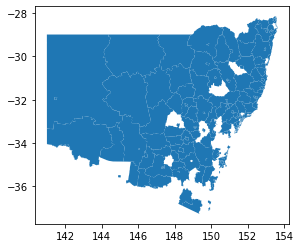

In [37]:
df_Live_Visual.plot()

plt.show()

## Result Table and Visulizations

In [45]:
df_result = df_Live[["area_name_x", "Liveability_Score", "geom", "geometry"]]

df_result = df_result.sort_values("Liveability_Score", ascending=False)

df_result.drop_duplicates(subset="area_name_x", inplace=True)

df_result.head()

,area_name_x,Liveability_Score,geom,geometry
19811,Badgerys Creek,1.000000,MULTIPOLYGON (((150.7211270030001 -33.87672600...,"POLYGON ((153.48931 -28.23313, 153.48950 -28.2..."
3893,Sydney - Haymarket - The Rocks,1.000000,MULTIPOLYGON (((151.22537899300005 -33.8552650...,"POLYGON ((152.89876 -29.66369, 152.89869 -29.6..."
6211,Chullora,0.999999,MULTIPOLYGON (((151.02884299100003 -33.8879799...,"POLYGON ((148.59966 -32.24288, 148.59945 -32.2..."
12229,North Sydney - Lavender Bay,0.999579,MULTIPOLYGON (((151.20195278200003 -33.8378120...,"POLYGON ((152.14904 -31.27748, 152.14913 -31.2..."
3332,Darlinghurst,0.998174,MULTIPOLYGON (((151.2122688500001 -33.87632702...,"POLYGON ((149.55269 -32.59241, 149.54475 -32.5..."


In [48]:
df_result.describe()

,Liveability_Score
count,271.000000
mean,0.396872
std,0.279291
min,0.002806
25%,0.165557
50%,0.302923
75%,0.614932
max,1.000000


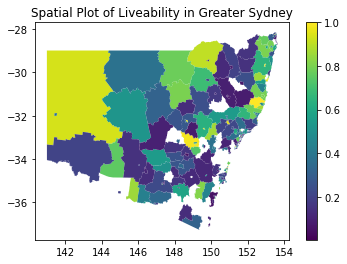

In [57]:
df_result.plot(column='Liveability_Score', legend = True)

plt.title("Spatial Plot of Liveability in Greater Sydney")

plt.show()

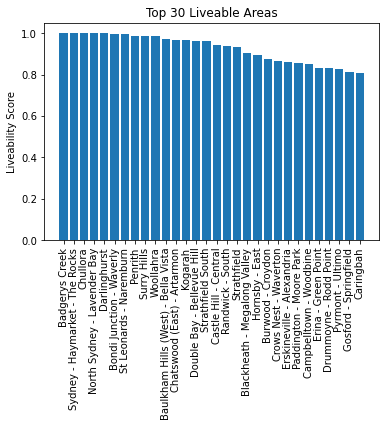

In [494]:
x = df_result["area_name_x"][0:30]
y = df_result["Liveability_Score"][0:30]

plt.bar(x, y)
plt.title("Top 30 Liveable Areas")
plt.xticks(rotation = 90)
plt.ylabel("Liveability Score")
plt.show()

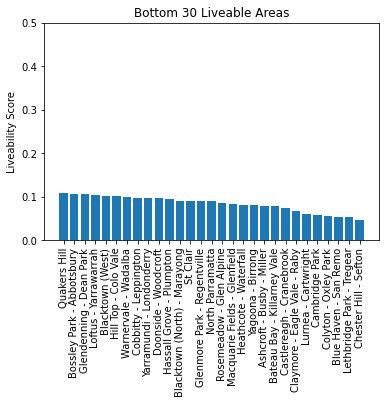

In [495]:
x = df_result["area_name_x"][-30:-1]
y = df_result["Liveability_Score"][-30:-1]

plt.bar(x, y)
plt.title("Bottom 30 Liveable Areas")
plt.xticks(rotation = 90)
plt.ylabel("Liveability Score")
plt.ylim(0, 0.5)
plt.show()

In [496]:
df_result = df_Live[["area_name_x", "Liveability_Score"]]

df_result = df_result.sort_values("Liveability_Score", ascending=False)

df_result.drop_duplicates(subset="area_name_x", inplace=True)

df_result.head()

,area_name_x,Liveability_Score
19811,Badgerys Creek,1.000000
3893,Sydney - Haymarket - The Rocks,1.000000
6211,Chullora,0.999999
12229,North Sydney - Lavender Bay,0.999579
3332,Darlinghurst,0.998174


## Correlations

In [497]:
df_result = df_Live[["area_name_x", "Liveability_Score", "avg_monthly_rent", "median_annual_household_income"]]

df_result = df_result.sort_values("Liveability_Score", ascending=False)

df_result.drop_duplicates(subset="area_name_x", inplace=True)

df_result.head()

,area_name_x,Liveability_Score,avg_monthly_rent,median_annual_household_income
19811,Badgerys Creek,1.000000,553.0,46021.0
3893,Sydney - Haymarket - The Rocks,1.000000,2998.0,27311.0
6211,Chullora,0.999999,2280.0,41625.0
12229,North Sydney - Lavender Bay,0.999579,2749.0,71668.0
3332,Darlinghurst,0.998174,2491.0,59293.0


### Correlation between Average Rent and Liveability Score

The correlation coefficient for Average Rent and Liveability Score is 0.48936557355016713


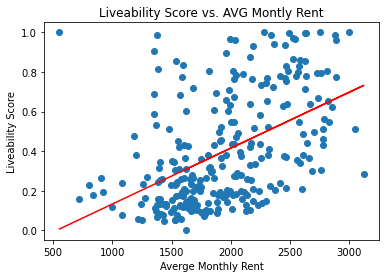

In [498]:
x = df_result["avg_monthly_rent"]
y = df_result["Liveability_Score"]


correlation = x.corr(y)

print(f"The correlation coefficient for Average Rent and Liveability Score is {correlation}")

b, m = polyfit(x, y, 1)
plt.scatter(x, y)
plt.title("Liveability Score vs. AVG Montly Rent")
plt.plot(x, b + m * x,  '-', color = "red")
plt.xlabel("Averge Monthly Rent")
plt.ylabel("Liveability Score")
plt.show()

### Correlation between Median House Income and Liveability Score

The correlation coefficient for Median  and Liveability Score is 0.2502081816756671


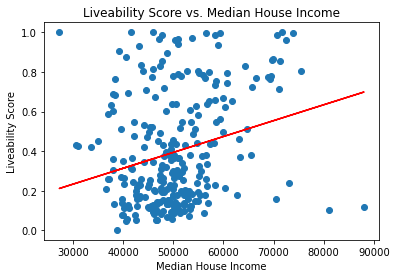

In [499]:
x = df_result["median_annual_household_income"]
y = df_result["Liveability_Score"]

correlation = x.corr(y)

print(f"The correlation coefficient for Median  and Liveability Score is {correlation}")

b, m = polyfit(x, y, 1)
plt.scatter(x, y)
plt.title("Liveability Score vs. Median House Income")
plt.plot(x, b + m * x,  '-', color = "red")
plt.xlabel("Median House Income")
plt.ylabel("Liveability Score")
plt.show()

# Task 3: Analysis the City of Sydney for our stakeholder

#### Our stakeholder is a graduated college student currently looking for a job in Sydney

## Extra KML and GeoJson datasets

In [500]:
# carshare = pd.read_xml("Car_share_bay_operator.kml") - Cannot susscuessfully import the KML data because of the lxml library issues
# Import the GeoJson instead

carshare = gpd.read_file("Car_share_bay_operator.geojson")

carshare.head()

,OBJECTID,Bay_ID,Operator,Street,Suburb,geometry
0,1,719,GoGet,Cross Street,Camperdown,POINT (151.18004 -33.88336)
1,2,828,Car Next Door,O'Connor Street,Chippendale,POINT (151.20062 -33.88604)
2,3,721,Hertz-Flexicar,Victoria Street,Potts Point,POINT (151.22241 -33.87412)
3,4,718,GoGet,Wolseley Grove,Zetland,POINT (151.21042 -33.90439)
4,5,723,Hertz-Flexicar,Riley Street,Darlinghurst,POINT (151.21537 -33.87442)


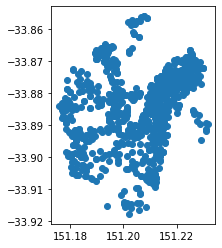

In [501]:
carshare.plot()

plt.show()

In [502]:
libraries = gpd.read_file(open("Library_locations.geojson"))

libraries.head()

,OBJECTID,Name,Streetnumber,Street,Streetextra,Suburb,Postcode,geometry
0,1,Waterloo Library,770,Elizabeth Street,,Waterloo,2017,POINT (151.20661 -33.89938)
1,2,Glebe Library,186,Glebe Point Road,,Glebe,2037,POINT (151.18490 -33.87798)
2,3,Darling Square Library,1,Little Pier Street,Level 1 + 2,Haymarket,2000,POINT (151.20220 -33.87794)
3,4,Kings Cross Library,50-52,Darlinghurst Road,Level 1,Potts Point,2011,POINT (151.22354 -33.87400)
4,5,Newtown Library,8-10,Brown Street,,Newtown,2042,POINT (151.18275 -33.89535)


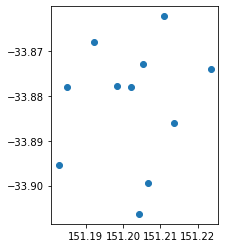

In [503]:
libraries.plot()

plt.show()

In [504]:
carshare.dropna(inplace=True)

libraries.dropna(inplace=True)

In [505]:
carshare.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 794 entries, 0 to 793
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   OBJECTID  794 non-null    int64   
 1   Bay_ID    794 non-null    int64   
 2   Operator  794 non-null    object  
 3   Street    794 non-null    object  
 4   Suburb    794 non-null    object  
 5   geometry  794 non-null    geometry
dtypes: geometry(1), int64(2), object(3)
memory usage: 37.3+ KB


In [506]:
libraries.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   OBJECTID      11 non-null     int64   
 1   Name          11 non-null     object  
 2   Streetnumber  11 non-null     object  
 3   Street        11 non-null     object  
 4   Streetextra   11 non-null     object  
 5   Suburb        11 non-null     object  
 6   Postcode      11 non-null     int64   
 7   geometry      11 non-null     geometry
dtypes: geometry(1), int64(2), object(5)
memory usage: 832.0+ bytes


In [507]:
carshare_copy = carshare.copy()  # Creating a copy of the original Libraries dataset
carshare['geom'] = carshare['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
carshare = carshare.drop(columns="geometry")  # Deleting the old copy of Libraries dataset
carshare.sample(5)

,OBJECTID,Bay_ID,Operator,Street,Suburb,geom
464,465,527,GoGet,Alexander Street,Paddington,POINT (151.226373974564 -33.8864216100274)
124,125,322,GoGet,Wyndham Street,Alexandria,POINT (151.198127362241 -33.8965787880142)
135,136,339,GoGet,Boundary Street,Darlinghurst,POINT (151.220441441309 -33.8813224201153)
773,774,800,Car Next Door,Kent Street,Millers Point,POINT (151.203464995554 -33.8580392228064)
357,358,424,GoGet,Hargrave Street,Darlinghurst,POINT (151.213154543574 -33.8768759552253)


In [508]:
conn.execute('''DROP TABLE IF EXISTS Carshare;
                CREATE TABLE Carshare(
                OBJECTID INT,
                Bay_ID INT,
                Operator TEXT,
                Street TEXT,
                Suburb TEXT,
                geometry GEOMETRY(POINT, 4326)
                )''')

carshare.to_sql("Carshare", con=conn, if_exists='replace', index=False, dtype={'geom': Geometry('POINT', srid)})

794

In [509]:
query(conn, 'select * from public."Carshare"')

,OBJECTID,Bay_ID,Operator,Street,Suburb,geom
0,1,719,GoGet,Cross Street,Camperdown,0101000020E6100000341022EBC2E562406AE4B3ED11F1...
1,2,828,Car Next Door,O'Connor Street,Chippendale,0101000020E6100000E2F377806BE66240995E8AA869F1...
2,3,721,Hertz-Flexicar,Victoria Street,Potts Point,0101000020E61000007C0B71FD1DE7624093D1C901E3EF...
3,4,718,GoGet,Wolseley Grove,Zetland,0101000020E610000045A728C8BBE66240536FE623C3F3...
4,5,723,Hertz-Flexicar,Riley Street,Darlinghurst,0101000020E61000006C640E54E4E66240232C69FBECEF...
...,...,...,...,...,...,...
789,790,831,Car Next Door,Liverpool Street,Darlinghurst,0101000020E61000007D3F920F01E76240D42F1C065EF0...
790,791,832,Car Next Door,Whitehorse Street,Newtown,0101000020E610000036EE90AABCE5624039F2FF110AF3...
791,792,185,GoGet,Greens Road,Paddington,0101000020E610000048483C4B11E76240317FB40B1DF1...
792,793,836,Car Next Door,Defries Avenue,Zetland,0101000020E610000077FB12F8C9E6624094D3ED4B30F4...


In [510]:
libraries_copy = libraries.copy()  # Creating a copy of the original Libraries dataset
libraries['geom'] = libraries['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
libraries = libraries.drop(columns="geometry")  # Deleting the old copy of Libraries dataset
libraries.sample(5)

,OBJECTID,Name,Streetnumber,Street,Streetextra,Suburb,Postcode,geom
1,2,Glebe Library,186,Glebe Point Road,,Glebe,2037,POINT (151.184901497694 -33.8779848554516)
7,8,Green Square Library,355,Botany Road,,Zetland,2017,POINT (151.204226917875 -33.906305138073)
2,3,Darling Square Library,1,Little Pier Street,Level 1 + 2,Haymarket,2000,POINT (151.202198222939 -33.8779405892706)
6,7,Town Hall Library Express,456,"Kent Street, Sydney","Level 1, Town Hall House",Sydney,2000,POINT (151.205286597179 -33.8729966938763)
4,5,Newtown Library,8-10,Brown Street,,Newtown,2042,POINT (151.182753065156 -33.8953528897625)


In [182]:
conn.execute('''DROP TABLE IF EXISTS Libraries;
                CREATE TABLE Libraries(
                OBJECTID INT,
                Name TEXT,
                Streetnumber TEXT,
                Street TEXT,
                Streetextra TEXT,
                Suburb TEXT,
                Postcode INT,
                geometry GEOMETRY(POINT, 4326)
                )''')

libraries.to_sql('Libraries', conn, if_exists='replace', index=False, dtype={'geom': Geometry('POINT', srid)})

11

In [43]:
query(conn, 'select * from public."Libraries"')

,OBJECTID,Name,Streetnumber,Street,Streetextra,Suburb,Postcode,geom
0,1,Waterloo Library,770,Elizabeth Street,,Waterloo,2017,0101000020E6100000000579829CE66240765CD3D91EF3...
1,2,Glebe Library,186,Glebe Point Road,,Glebe,2037,0101000020E610000078B28BB6EAE562402246C8CE61F0...
2,3,Darling Square Library,1,Little Pier Street,Level 1 + 2,Haymarket,2000,0101000020E6100000A25A686878E66240C55F735B60F0...
3,4,Kings Cross Library,50-52,Darlinghurst Road,Level 1,Potts Point,2011,0101000020E6100000B31A1B3E27E762405D689A5BDFEF...
4,5,Newtown Library,8-10,Brown Street,,Newtown,2042,0101000020E6100000D7C2F41CD9E562405BF469EC9AF2...
5,6,Surry Hills Library,405,Crown Street,,Surry Hills,2010,0101000020E61000008E2B038CD6E662404CBA923469F1...
6,7,Town Hall Library Express,456,"Kent Street, Sydney","Level 1, Town Hall House",Sydney,2000,0101000020E61000001CA632B591E6624080DB0C5BBEEF...
7,8,Green Square Library,355,Botany Road,,Zetland,2017,0101000020E61000008DA7E30689E66240331C88CE01F4...
8,9,Pyrmont Link,,Corner of John and Mount Streets,Pyrmont Community Centre,Pyrmont,2009,0101000020E61000004EA5879F26E662401B3A1E631CEF...
9,10,Customs House Library,31,Alfred Street,,Sydney,2000,0101000020E6100000DFB79830BFE66240EB41F55D5EEE...


<AxesSubplot:>

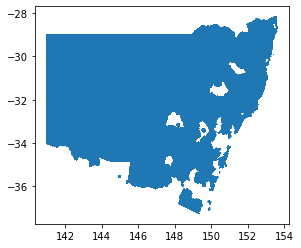

In [511]:
df_Live.plot()

In [512]:
merged = carshare_copy.merge(libraries_copy, on = "Street", how='left')

merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 794 entries, 0 to 793
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   OBJECTID_x    794 non-null    int64   
 1   Bay_ID        794 non-null    int64   
 2   Operator      794 non-null    object  
 3   Street        794 non-null    object  
 4   Suburb_x      794 non-null    object  
 5   geometry_x    794 non-null    geometry
 6   OBJECTID_y    25 non-null     float64 
 7   Name          25 non-null     object  
 8   Streetnumber  25 non-null     object  
 9   Streetextra   25 non-null     object  
 10  Suburb_y      25 non-null     object  
 11  Postcode      25 non-null     float64 
 12  geometry_y    25 non-null     geometry
dtypes: float64(2), geometry(2), int64(2), object(7)
memory usage: 86.8+ KB


In [513]:
geometry = carshare_copy["geometry"]

merged = gpd.GeoDataFrame(merged, crs="EPSG:4326", geometry=geometry)

df_Live = df_Live.rename(columns={'index_left':'other_name', 'index_right':'other_names'})

merged = merged.to_crs(4283)

df_Live = df_Live.sjoin(merged, how="left")

## Recalculate the Liveability Score for our stakeholder

### Creating a new index "population density" and "business density" in areas

In [58]:
df_Live["population_density"] = df_Live["population"]/df_Live["land_area"]

In [59]:
df_Live["number_of_dwellings"] = df_Live["number_of_dwellings"].str.replace(",","")

df_Live["number_of_dwellings"] = pd.to_numeric(df_Live["number_of_dwellings"])

df_Live["business_density"] = (df_Live['number_of_dwellings'] + df_Live["number_of_businesses_x"]) / df_Live['land_area']

### Additional z score

In [60]:
df_Live["z_population"] = (df_Live["population_density"] - df_Live["population_density"].mean())/df_Live["population_density"].std(ddof=0)

df_Live["z_business"] = (df_Live["business_density"] - df_Live["business_density"].mean())/df_Live["business_density"].std(ddof=0)

In [63]:
df_Live["y"] = df_Live["z_population"] + 3*df_Live["z_business"]+ 0*df_Live["z_school"] + 2*df_Live["z_accom"] + 1.5*df_Live["z_retail"] - 3*df_Live["z_crime"] + 0.5*df_Live["z_health"]

df_Live["new_Liveability_Score"] = 1 / (1 + np.exp(-df_Live["y"]))

df_Live.head()

df_result = df_Live[["area_name_x", "new_Liveability_Score", "geom", "geometry"]]

df_result = df_result.sort_values("new_Liveability_Score", ascending=False)

df_result.drop_duplicates(subset="area_name_x", inplace=True)

df_result.sample(10)

,area_name_x,new_Liveability_Score,geom,geometry
20648,Bossley Park - Abbotsbury,0.029377,MULTIPOLYGON (((150.87097811900003 -33.8564573...,"POLYGON ((148.19930 -35.29544, 148.19936 -35.2..."
4856,Malabar - La Perouse - Chifley,0.066929,MULTIPOLYGON (((151.2267246020001 -33.96389753...,"MULTIPOLYGON (((153.20787 -30.09639, 153.20783..."
6204,Chullora,0.999994,MULTIPOLYGON (((151.02884299100003 -33.8879799...,"POLYGON ((148.59966 -32.24288, 148.59945 -32.2..."
13195,Cromer,0.027967,MULTIPOLYGON (((151.2557539280001 -33.73282467...,"POLYGON ((146.89189 -36.06251, 146.89168 -36.0..."
20378,Hinchinbrook,0.032601,MULTIPOLYGON (((150.8737579220001 -33.91085907...,"POLYGON ((145.25945 -34.18053, 145.25798 -34.1..."
19134,Macquarie Park - Marsfield,0.168359,MULTIPOLYGON (((151.09561401000008 -33.7786900...,"POLYGON ((153.25827 -28.80044, 153.25835 -28.7..."
20526,West Hoxton - Middleton Grange,0.019482,MULTIPOLYGON (((150.82730302200002 -33.9234659...,"POLYGON ((146.19798 -34.78801, 146.20083 -34.7..."
13361,Forestville - Killarney Heights,0.082258,MULTIPOLYGON (((151.19578895400002 -33.7540253...,"POLYGON ((146.63805 -35.64634, 146.63809 -35.6..."
13742,Campbelltown - Woodbine,0.568434,MULTIPOLYGON (((150.77834002400004 -34.0705705...,"POLYGON ((145.46159 -35.66979, 145.46163 -35.6..."
16150,Penrith,0.847549,MULTIPOLYGON (((150.67709683500004 -33.7516410...,"POLYGON ((151.62930 -32.93132, 151.62942 -32.9..."


## Visulize the new results

In [64]:
df_result.describe()

,new_Liveability_Score
count,2.710000e+02
mean,3.860495e-01
std,3.898288e-01
min,8.051704e-07
25%,3.126316e-02
50%,1.886187e-01
75%,7.971547e-01
max,1.000000e+00


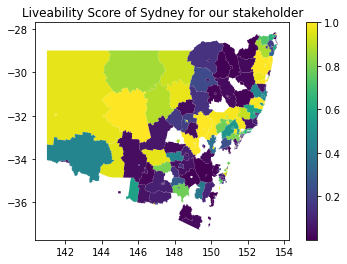

In [66]:
df_result.plot(column='new_Liveability_Score', legend=True)

plt.title("Liveability Score of Sydney for our stakeholder")

plt.show()

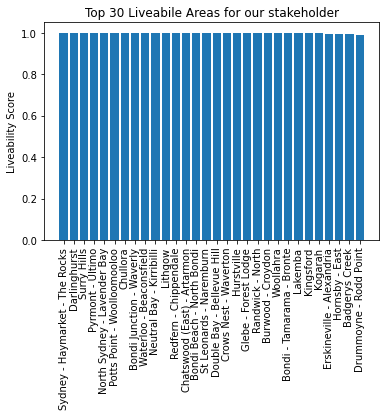

In [519]:
x = df_result["area_name_x"][0:30]
y = df_result["new_Liveability_Score"][0:30]

plt.bar(x, y)
plt.title("Top 30 Liveabile Areas for our stakeholder")
plt.xticks(rotation = 90)
plt.ylabel("Liveability Score")
plt.show()

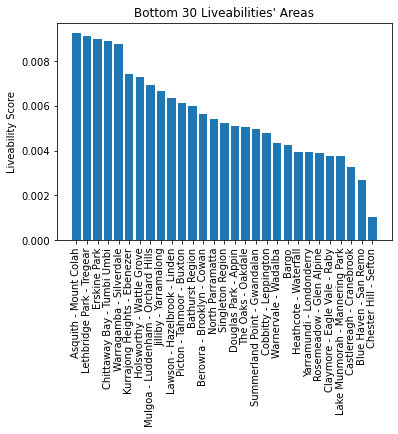

In [520]:
x = df_result["area_name_x"][-30:-1]
y = df_result["new_Liveability_Score"][-30:-1]

plt.bar(x, y)
plt.title("Bottom 30 Liveabilities' Areas")
plt.xticks(rotation = 90)
plt.ylabel("Liveability Score")
plt.show()

## New Correlations

In [521]:
df_result = df_Live[["area_name_x", "new_Liveability_Score", "public_administration_and_safety", "accommodation_and_food_services"]]

df_result = df_result.sort_values("new_Liveability_Score", ascending=False)

df_result.drop_duplicates(subset="area_name_x", inplace=True)

df_result.head()

,area_name_x,new_Liveability_Score,public_administration_and_safety,accommodation_and_food_services
3890,Sydney - Haymarket - The Rocks,1.0,114,1685
3330,Darlinghurst,1.0,3,195
3798,Surry Hills,1.0,15,275
3586,Pyrmont - Ultimo,1.0,19,231
12228,North Sydney - Lavender Bay,1.0,14,222


The correlation coefficient for public administration and safety and Liveability Score is 0.25466845559282736


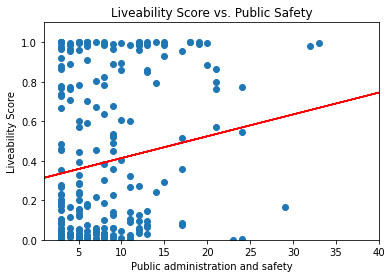

In [522]:
x = df_result["public_administration_and_safety"]
y = df_result["new_Liveability_Score"]


correlation = x.corr(y)

print(f"The correlation coefficient for public administration and safety and Liveability Score is {correlation}")

b, m = polyfit(x, y, 1)
plt.scatter(x, y)
plt.title("Liveability Score vs. Public Safety")
plt.plot(x, b + m * x,  '-', color = "red")
plt.xlabel("Public administration and safety")
plt.ylabel("Liveability Score")
plt.xlim(1,40)
plt.ylim(0,1.1)
plt.show()

The correlation coefficient for accomodation food services and Liveability Score is 0.38867409170036743


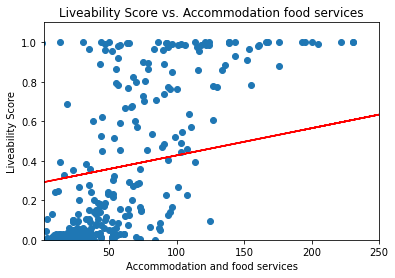

In [523]:
x = df_result["accommodation_and_food_services"]
y = df_result["new_Liveability_Score"]


correlation = x.corr(y)

print(f"The correlation coefficient for accomodation food services and Liveability Score is {correlation}")

b, m = polyfit(x, y, 1)
plt.scatter(x, y)
plt.title("Liveability Score vs. Accommodation food services")
plt.plot(x, b + m * x,  '-', color = "red")
plt.xlabel("Accommodation and food services")
plt.ylabel("Liveability Score")
plt.xlim(2, 250)
plt.ylim(0, 1.1)
plt.show()

# End of the Project

## Disconnect

In [524]:
conn.close()
db.dispose()